# Importing Libraries

In [19]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sentencepiece as spm

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.text import Tokenizer
# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from helper import *

# Loading Data

In [2]:
data_path = '../data/four_channels.csv'
df = pd.read_csv(data_path)
as_unicode = ("👍", "❤", "🤬", "😢", "😁")
emoji = ("like", "heart", "angry", "sad", "laugh")

df = df[['text'] + list(as_unicode)]
df.columns = ['text'] + list(emoji)
df = df.fillna(0)

# merge like+heart=positive, angry+sad=negative, laugh=mixed
df['positive'] = df['like'] + df['heart']
df['negative'] = df['angry'] + df['sad']
df['mixed'] = df['laugh']

df = df.drop(columns=["like", "heart", "angry", "sad", "laugh"])

df.head()

,text,positive,negative,mixed
0,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,892.0,16.0,0.0
1,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",702.0,298.0,0.0
2,У Польщі запрацював хаб з ремонту танків Leopa...,2874.0,10.0,0.0
3,У Києві затримали колишнього віськкома-втікача...,2662.0,12.0,0.0
4,‼️ Через війну ціни в Києві виросли на 247%. \...,177.0,928.0,0.0


In [3]:
def filter_string_rows(df):
    return df[df['text'].apply(lambda x: isinstance(x, str))]

def scale_values(df):
    # convert emoji values to int
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)

    # scale values to 0-1 for emoji
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda row: row / max(row.sum(), 0.1**10), axis=1)

    return df

def to_lower(df):
	df['text'] = df['text'].apply(lambda x: x.lower())
	return df

def articles_and_labels(df):
    return df['text'].tolist(), df[df.columns[1:]].values.tolist()

def argmax_labels(labels):
    # from [0.1, 0.2, 0.7] to [0, 0, 1]
    one_hot_labels = np.eye(len(labels[0]))
    return [one_hot_labels[np.argmax(label)] for label in labels]

df_copy = df.copy()
df_copy = filter_string_rows(df_copy)
df_copy = to_lower(df_copy)
df_copy = scale_values(df_copy)
articles, labels = articles_and_labels(df_copy)
labels = argmax_labels(labels)
print(f"Articles: {len(articles)}, Labels: {len(labels)}")
print(f"Example: {articles[0]}, {labels[0]}")

Articles: 75469, Labels: 75469
Example: 🧡 кадрові зміни у кабміні. новим керівником мінкульту може стати антон дробович, очільник інституту національної пам’яті або олеся островська-люта, директорка «мистецького арсеналу».

«дробович — це буде міністр-воїн, який вміє формувати вірні наративи та має зважено доносити історичний багаж. проте до кандидатури островської-лютої більш схильні на банковій», — кажуть наші джерела у парламенті. 

як нам стало відомо, крісло хитається ще й під міністром молоді і спорту вадимом гутцайтом. 

times of ukraine , [1. 0. 0.]


In [4]:
tokenizer = spm.SentencePieceProcessor(model_file='./tokenizer/spm_50000.model')

print(f"Vocab size: {tokenizer.vocab_size()}")

Vocab size: 50000


In [5]:
articles_encoded = tokenizer.encode(articles)

In [6]:
def words_per_article(articles):
    # calculate words in each article
    words_in_articles = [len(article) for article in articles]

    # calculate min, max, mean
    min_words = min(words_in_articles)
    max_words = max(words_in_articles)
    mean_words = sum(words_in_articles) / len(articles)

    return min_words, max_words, mean_words

min_words, max_words, mean_words = words_per_article(articles_encoded)
print(f"Min Words: {min_words}, Max Words: {max_words}, Mean Words: {mean_words}")

Min Words: 0, Max Words: 1176, Mean Words: 63.47974665094277


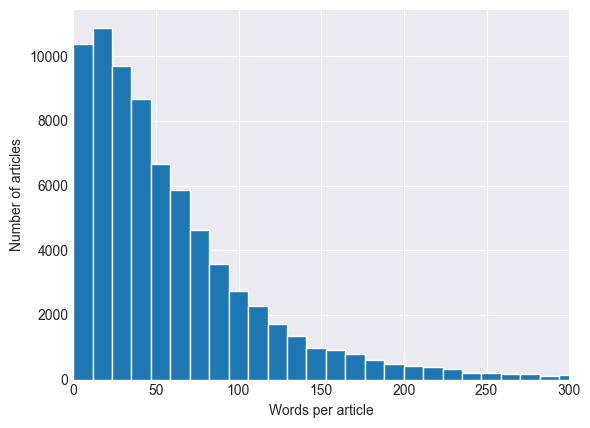

In [7]:
# plot distribution of words per article
words_per_article = [len(article) for article in articles_encoded]
plt.hist(words_per_article, bins=100)
plt.xlabel('Words per article')
plt.ylabel('Number of articles')
plt.xlim(0, 300)
plt.show()

In [8]:
(train_articles, train_labels), (test_articles, test_labels) = split_data(articles_encoded, labels, 0.8)
print(f"Train articles: {len(train_articles)}, Train labels: {len(train_labels)}")
print(f"Test articles: {len(test_articles)}, Test labels: {len(test_labels)}")

Train articles: 60375, Train labels: 60375
Test articles: 15094, Test labels: 15094


In [9]:
# pad sequences
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
vocab_size = tokenizer.vocab_size()

train_padded = pad_sequences(train_articles, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_articles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(f"Train padded: {len(train_padded)}, Test padded: {len(test_padded)}")
print(f"Train labels: {len(train_labels)}, Test labels: {len(test_labels)}")

Train padded: 60375, Test padded: 15094
Train labels: 60375, Test labels: 15094


In [10]:
import keras.layers as L

def create_model(vocab_size, embedding_dim, max_length):
    input = L.Input(shape=(max_length,))
    x = L.Embedding(vocab_size, embedding_dim)(input)
    x = L.Flatten()(x)
    x = L.Dense(64, activation="relu")(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(3, activation="softmax")(x)
    model = tf.keras.Model(inputs=input, outputs=x)
    return model

embedding_dim = 16

model = create_model(vocab_size, embedding_dim, max_length)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 16)           800000    
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 64)                204864    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1005059 (3.83 MB)
Trainable params: 1005059 (3.

In [11]:
num_epochs = 10
batch_size = 128
model_name = "emoji_model-spm50k-embed16"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../models/{model_name}_checkpoint.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
history = model.fit(
    train_padded, train_labels, 
    epochs=num_epochs, 
    validation_data=(test_padded, test_labels), 
    callbacks=[checkpoint_callback],
    batch_size=batch_size
)

Epoch 1/10
472/472 [==============================] - 4s 7ms/step - loss: 0.8337 - accuracy: 0.6276 - val_loss: 0.7467 - val_accuracy: 0.6722
Epoch 2/10
 17/472 [>.............................] - ETA: 2s - loss: 0.7435 - accuracy: 0.6631

C:\#Coding\Python\_uvPythonEnvironment\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/472 [==============================] - 3s 7ms/step - loss: 0.6496 - accuracy: 0.7468 - val_loss: 0.5620 - val_accuracy: 0.7851
Epoch 3/10
472/472 [==============================] - 3s 7ms/step - loss: 0.5084 - accuracy: 0.8062 - val_loss: 0.5005 - val_accuracy: 0.8030
Epoch 4/10
472/472 [==============================] - 4s 7ms/step - loss: 0.4378 - accuracy: 0.8330 - val_loss: 0.4689 - val_accuracy: 0.8142
Epoch 5/10
472/472 [==============================] - 3s 7ms/step - loss: 0.3823 - accuracy: 0.8531 - val_loss: 0.4538 - val_accuracy: 0.8205
Epoch 6/10
472/472 [==============================] - 3s 7ms/step - loss: 0.3328 - accuracy: 0.8741 - val_loss: 0.4463 - val_accuracy: 0.8254
Epoch 7/10
472/472 [==============================] - 3s 7ms/step - loss: 0.2848 - accuracy: 0.8964 - val_loss: 0.4492 - val_accuracy: 0.8256
Epoch 8/10
472/472 [==============================] - 3s 7ms/step - loss: 0.2408 - accuracy: 0.9152 - val_loss: 0.4534 - val_accuracy: 0.8289
Epoch 9/10
472/47

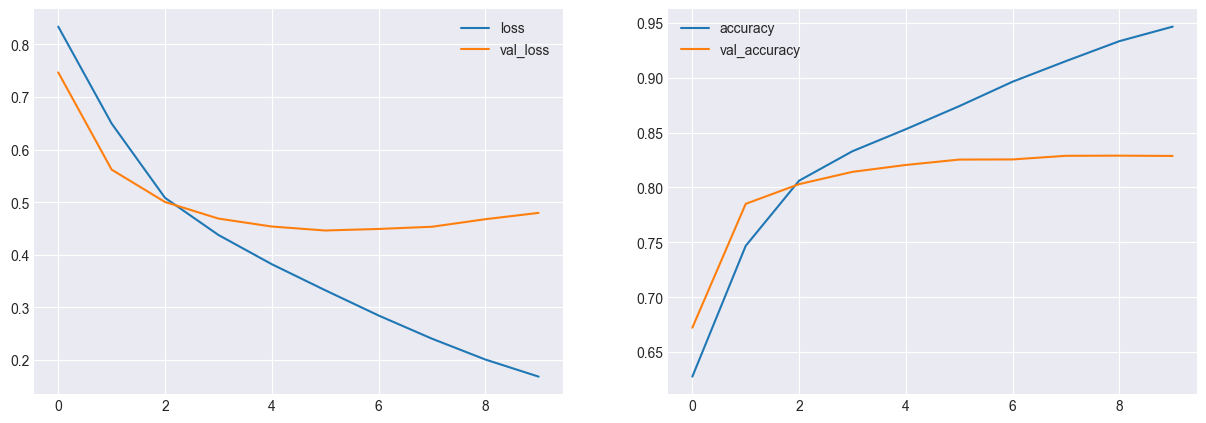

In [12]:
def plot_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

def plot_history_as_subplots(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.legend()
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.legend()
    plt.show()

plot_history_as_subplots(history)

In [13]:
# load best model
model = tf.keras.models.load_model(f"../models/{model_name}_checkpoint.h5")

# evaluate on test data
model.evaluate(test_padded, test_labels)

472/472 [==============================] - 1s 932us/step - loss: 0.4677 - accuracy: 0.8290


[0.46770524978637695, 0.8290048837661743]

472/472 [==============================] - 0s 920us/step


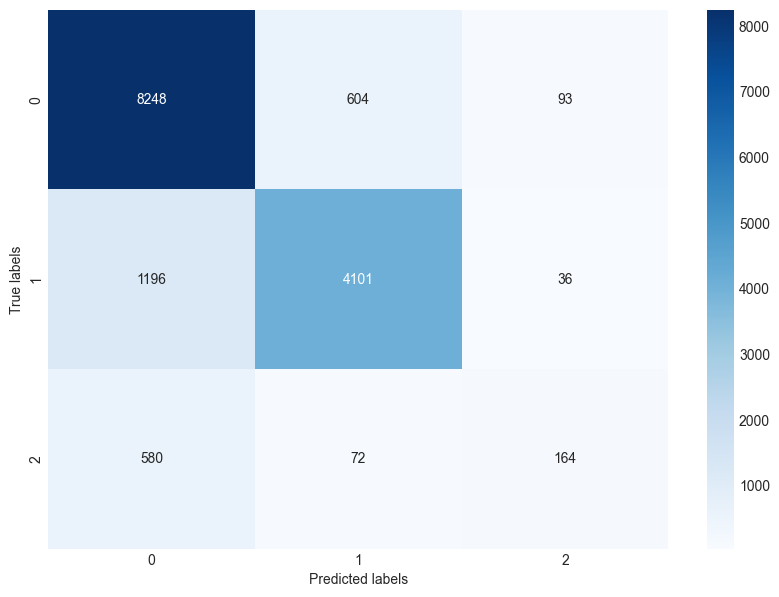

In [20]:
# predict on test data
predictions = model.predict(test_padded)
predictions = np.argmax(predictions, axis=1)

# get true labels
true_labels = np.argmax(test_labels, axis=1)

# get confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predictions)

# plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [25]:
# get few articles with good predictions
good_predictions = []
for i in range(len(test_labels)):
    if true_labels[i] == predictions[i]:
        good_predictions.append((test_articles[i], true_labels[i], predictions[i]))
        
print(f"Good predictions: {len(good_predictions)}")

# get actual articles
for i in range(15):
    article, true_label, predicted_label = good_predictions[i]
    print(f"Article: {tokenizer.decode(article)}")
    print(f"True label: {true_label}, Predicted label: {predicted_label}")
    print()

Good predictions: 12513
Article: бойовий медик на позивний швепс служить у 25-ій бригаді імені князя аскольда нацгвардії україни. він рятував побратимів у бахмуті. «там складно, проте стабільно. вони кожен день наступають, ми даємо їм відсіч. під час наступу ворог використовував артилерію, танки, авіацію. було таке, що ми сиділи в одній посадці з вагнерівцями, переважно колишніми злочинцями. у тій посадці вони й залишались». наші воїни вже на рівні рефлексів відчувають ворога, а тому щоразу дають блискавичну та вибухову відповідь🔥 «наше військове зобов‘язання – берегти україну», — підкреслює герой. підтримуємо і розділяємо це. бережемо україну та рухаємося до перемоги! джерело: нацгвардія україни.
True label: 0, Predicted label: 0

Article: актуальна інформація щодо залізничного сполучення та функціонування вокзалів.
True label: 0, Predicted label: 0

Article: нато має готуватися до можливого поглинання росією білорусі, - isw аналітики американського інституту вивчення війни (isw) згад

In [14]:
# save model
model.save(f"../models/{model_name}.h5")

# save tokenizer
with open(f"../models/{model_name}_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

C:\#Coding\Python\_uvPythonEnvironment\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


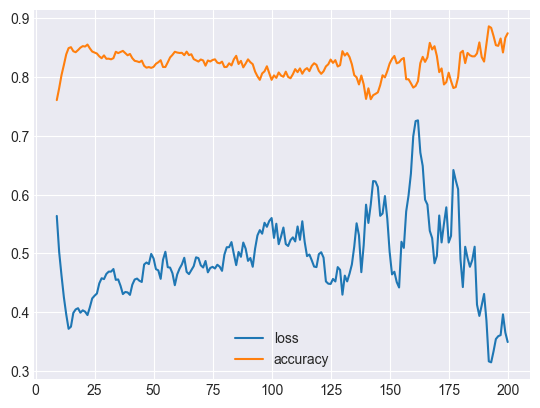

In [15]:
splited = {}
for i in range(len(test_labels)):
    varticle = test_articles[i]
    vanswer = test_labels[i]

    length = len(varticle)
    if length > max_length:
        continue
    if length not in splited:
        splited[length] = []

    splited[length].append((varticle, vanswer))

results = {}
# sort splited by length
splited = dict(sorted(splited.items(), key=lambda item: item[0]))
for key in splited:
    varticles = [row[0] for row in splited[key]]
    vanswers = [row[1] for row in splited[key]]
    varticles_padded = pad_sequences(varticles, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    vanswers = np.array(vanswers)
    # print(f"Length: {key}, Articles: {len(varticles)}, Answers: {len(vanswers)}")
    pred = model.evaluate(varticles_padded, vanswers, verbose=0)
    # get mean of loss and accuracy
    results[key] = (pred[0], pred[1])

# make df from results
results_df = pd.DataFrame(results.items(), columns=["Length", "Results"])
# use rolling mean to smooth the data
results_df["Loss"] = results_df["Results"].apply(lambda x: x[0]).rolling(10).mean()
results_df["Accuracy"] = results_df["Results"].apply(lambda x: x[1]).rolling(10).mean()
results_df = results_df.drop(columns=["Results"])

# plot results
plt.plot(results_df["Length"], results_df["Loss"], label="loss")
plt.plot(results_df["Length"], results_df["Accuracy"], label="accuracy")
plt.legend()
plt.show()